# Normalized Vegetation Index (NDVI)

The Normalized Difference Vegetation Index (NDVI) quantifies vegetation by measuring the difference between near-infrared **nir** (which vegetation strongly reflects) and **red** light (which vegetation absorbs). NDVI always ranges from -1 to +1.

* **Negative Values:** It is most likely water.
* **Values Close to 1:** There is a high possibility that they are dense green leaves.
* **Values Close to 0:** There are no green leaves and it could even be an urbanized area.

<img src="resources/ndvi_example.png" alt="Drawing" style="width: 400px;"/>

## Content

1. Undertading Landsat 8 OLI LASRC Scene Data
2. Query Datacube
3. Cloud Masking
4. NDVI Calculation

## Undertading Landsat 8 OLI LASRC Scene Data

The Landsat 8 OLI LASRC scenes taken in this work are images belonging to **Collection 1 - Level 2 (On demand)** of the USGS Earth Explorer image catalog. In particular, Level 2 scenes apply atmospheric corrections called **Surface Reflectance (SR) Correction**. These corrections mitigate the effect of gases and aerosols found in the atmosphere, because gases and aerosols affect the reflectance emited by the earth and read by the satellite (sensor). Atmospheric corrections are carried out in Landsat 8 OLI scenes by the **LASRC (Landsat Surface Reflectance Code) algorithm**.

During the generation of surface reflectance corrected scenes, the LASRC algorithm evaluates the quality of each pixel, the information of this evaluation is recorded in 3 bands (`sr_aerosol`, `pixel_qa`, `radsat_qa`) that are additionally generated at the end of the reflectance correction.

Information on the valid values for each band is found below:

* band_1 (coastal_aerosol): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_2 (blue): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_3 (green): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_4 (red): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_5 (nir): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_6 (swir1): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_7 (swir2): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* pixel_qa (pixel_qa): rango=0,32768 rango_valido=0,32768
* sr_aerosol (sr_aerosol_qa, aerosol_qa, aerosol): rango=0,255; rango_valido=0,255
* radsat_qa (radsat_qa): rango=0,32768 rango_valido=0,32768

#### References

1. [Designación de Bandas para Satelites Landsat](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products)
2. [Evaluación de la Calidad de los Pixeles en Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8-surface-reflectance-quality-assessment?qt-science_support_page_related_con=1#qt-science_support_page_related_con)
3. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)

In [1]:
%%time

import datacube

dc = datacube.Datacube(app="NDVI")

xarr = dc.load(
    # Satellite 
    product="LS8_OLI_LASRC",
    
    # Area to be requested 0.23738925
    latitude=(3.75702418296, 3.99441343296),
    longitude=(-70.402981323, -70.166735698),
    # Time format (YYYY-MM-DD)
    # time=("2017-12-21","2017-12-23"),

    # Image spectral bands
    measurements=['red', 'green', 'blue'],
    output_crs='EPSG:4326',
    resolution=(-0.000271302,0.000269995)
)

xarr

CPU times: user 3.56 s, sys: 1.13 s, total: 4.68 s
Wall time: 16.6 s


<xarray.Dataset>
Dimensions:      (latitude: 876, longitude: 876, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2017-12-22T14:54:24
  * latitude     (latitude) float64 3.995 3.994 3.994 ... 3.758 3.757 3.757
  * longitude    (longitude) float64 -70.4 -70.4 -70.4 ... -70.17 -70.17 -70.17
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 592 567 448 ... 302 265 264
    green        (time, latitude, longitude) int16 650 629 591 ... 478 474 456
    blue         (time, latitude, longitude) int16 328 317 263 ... 237 212 218
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

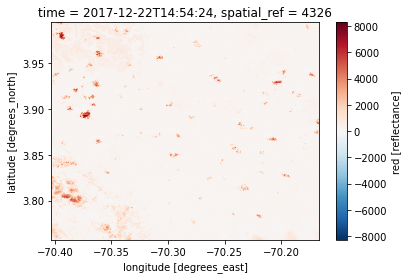

In [25]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(400,600))
# fig, axes = plt.subplots(1,figsize=(15,10))
# xarr.red.plot(ax=axes)
# plt.tight_layout()

xarr.red.plot()

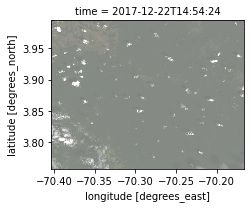

In [21]:
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import CRS

from matplotlib import pyplot as plt

crs_obj = CRS(xarr.crs)

data = mask_invalid_data(xarr)

fake_saturation = 4000
rgb = data.to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
rgb /= fake_saturation  # scale to [0, 1] range for imshow

rgb.plot.imshow(
    x = crs_obj.dimensions[1], 
    y = crs_obj.dimensions[0],
    col='time', 
#     col_wrap=5, 
    add_colorbar=False,
#     interpolation='nearest',
#     aspect='auto'
)

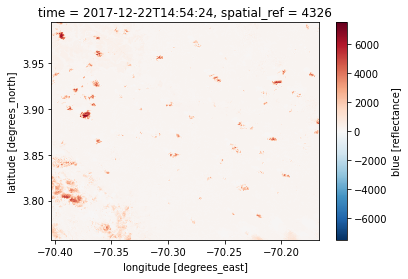

In [22]:
data.blue.plot()

## Cloud Masking

Clouds and atmospheric conditions present a significant challenge when working with multispectral remote sensing data. Extreme clouds and shadows can generate non usable data. In principle the clouds scatter all the light emitted by the sun causing it to return to the sensor without relevant data. On the other hand, light is absorbed or blocked, in this case the amount of data read from the earth's surface is also irrelevant.

Reflectance corrected landsat images come with quality layers (pixel_qa) that allow detecting the presence of clouds, shadow and even water in the monitoring. This layer will allow us to identify and eliminate pixels that are not useful for analysis. The following table shows the representation of each of the values that can be found for each pixel of the `pixel_qa` band.

| Attribute                | Pixel Value                                                     |
|--------------------------|-----------------------------------------------------------------|
| Fill                     | 1                                                               |
| Clear                    | 322, 386, 834, 898, 1346                                        |
| Water                    | 324, 388, 836, 900, 1348                                        |
| Cloud shadow             | 328, 392, 840, 904, 1350                                        |
| Snow/ice                 | 336, 368, 400, 432, 848, 880, 912, 944, 1352                    |
| Cloud                    | 352, 368, 416, 432, 480, 864, 880, 928, 944, 992                |
| Low confidence cloud     | 322, 324, 328, 336, 352, 368, 834, 836, 840, 848, 864, 880      |
| Medium confidence cloud  | 386, 388, 392, 400, 416, 432, 898, 900, 904, 928, 944           |
| High confidence cloud    | 480, 992                                                        |
| Low confidence cirrus    | 322, 324, 328, 336, 352, 368, 386, 388, 392, 400, 416, 432, 480 |
| High confidence cirrus   | 834, 836, 840, 848, 864, 880, 898, 900, 904, 912, 928, 944, 992 |
| Terrain occlusion        | 1346, 1348, 1350, 1352                                          |


#### References

1. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf)
2. [Clean Remote Sensing Data in Python - Clouds, Shadows & Cloud Masks](https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/cloud-masks-with-spectral-data-python/)

In [ ]:
def cloud_mask(band,pixel_qa):
    """
    Enmascara o hace igual a NaN aquellos pixeles que no son 
    relevantes para el análisis, como aquellos pixeles donde se
    presentan nubes, nieve en todas sus modalidades.
    
    Args:
        band (xarray.DataArray): Banda o respuesta espectral (red,blue,green,etc).
        pixel_qa (xarray.DataArray): The pixel quality band.
        
    Returns:
        xarray.DataArray: Matrix donde las nubes ha sido removidas (nodata). 
    """
    
    nodata=-9999
    
    # VALORES VALIDOS PARA ANALISIS PRESENTES EN 
    # LA BANDA PIXEL_QA
    
    # Para este caso únicamente nos interesa conservar 
    # aquellos pixeles cuya obvercación es clara y 
    # además pixeles que pueden mostrar información 
    # acerca del agua
    clear = [322, 386, 834, 898, 1346]
    water = [324, 388, 836, 900, 1348]
    valid_values = clear + water

    # Aquellos pixeles cuyos valor esten en valid_values tendran un
    # valor de True en la corrspondiente posición en la matrix mask_1 
    # indicando que son pixeles validos para analisis. Aquellos pixeles 
    # cuyos valores no esten en valid_values tendran un valor de False 
    # en mask_1.
    mask_1 = np.isin(pixel_qa.values, valid_values)

    # Marca como True aquellos pixeles que tienen información, es decir, 
    # no son igual a nodata=-9999.
    has_information = band != nodata

    # Aquellos pixeles que tienen información (has_information[i][j] = True)
    # y son pixeles validos mask_1[i][j] = True, seguirán siendo válidos, es
    # decir, mask_2[i][j] = True. En caso contrarion mask_2[i][j] = False.
    mask_2 = np.logical_and(has_information,mask_1)

    # Para pixeles validos mask_2[i][j] = True, entonces 
    # new_band_data_array[i][j] = band_data_array[i][j]. 
    # En caso contrario, new_band_data_array[i][j] = NaN.
    new_band_data_array = np.where(mask_2,band,np.nan)
    return new_band_data_array

## NDVI Calculation 



### Referencia

1. [What is NDVI (Normalized Difference Vegetation Index)?](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/)

In [ ]:
def ndvi(red,nir):
    """Indice de Vegetación Normalizado.
    
    Args:
        red (xarray.DataArray): Banda red .
        nir (xarray.DataArray): Banda nir.
        
    Returns:
        xarray.DataArray: Matr
    """
    # Obteniendo los valores de las bandas. 
    # los valores son np.array
    period_red = red.values
    period_nir = nir.values

    # Si los pixeles en 'red' o 'nir' tiene valoes NaN entonces 
    # mask_nan = True
    mask_nan=np.logical_or(np.isnan(period_red), np.isnan(period_nir))

    # NDVI computation
    period_nvdi = (period_nir-period_red) / (period_nir+period_red)

    # Remover pixeles invalidos
    period_nvdi[mask_nan] = np.nan

    # Remover valores mayores de 1 e inferiores a -1
    # Ya que el indice está definido entre -1 y 1.
    period_nvdi[period_nvdi>1] = np.nan
    period_nvdi[period_nvdi<-1] = np.nan

    data_array = xr.DataArray(data=period_nvdi)
    return data_array